# Regular Iterative Mandelbrot Set Computation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

def mandelbrot_iterative(nx, ny, z, Z, result):
    for i in range(nx):
        for j in range(ny):
            iters = 0
            z = 0
            while np.abs(z) < 2 and iters < 20:
                z = z**2 + Z[i, j]
                iters += 1
            result[i, j] = iters

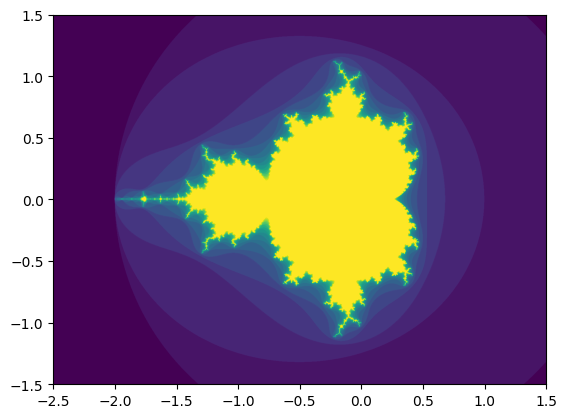

Time taken by iterative: 12.198149574000126


In [2]:
nx, ny = 1600, 1200
result = np.ones((nx, ny), dtype=np.int32)*19
x, y = np.mgrid[-2.5:1.5:nx*1j, -1.5:1.5:ny*1j]
Z = x + 1j*y
z = np.zeros_like(Z)

it_time = time.perf_counter()
mandelbrot_iterative(nx, ny, z, Z, result)
it_time = time.perf_counter() - it_time
plt.imshow(result.T, extent=[-2.5, 1.5, -1.5, 1.5])
plt.show()
print("Time taken by iterative:", it_time)

# Regular Numpy Vectorised Mandelbrot Set Computation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

def mandelbrot_numpy_vectorised(z, Z, result):
    z = np.zeros_like(Z)
    div = np.ones_like(z, dtype=bool)
    for i in range(20):
        ndiv = ~div
        z[ndiv] = z[ndiv]**2 + Z[ndiv]
        #z = z**2 + Z
        div = np.abs(z) > 2
        result[div & (result == 19)] = i

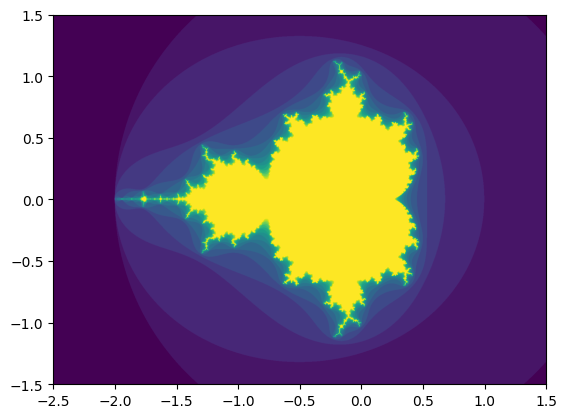

Time taken by numpy vectorised: 0.5674499739998282


In [4]:
nx, ny = 1600, 1200
result = np.ones((nx, ny), dtype=np.int32)*19
x, y = np.mgrid[-2.5:1.5:nx*1j, -1.5:1.5:ny*1j]
Z = x + 1j*y
z = np.zeros_like(Z)

np_time = time.perf_counter()
mandelbrot_numpy_vectorised(z, Z, result)
np_time = time.perf_counter() - np_time
plt.imshow(result.T, extent=[-2.5, 1.5, -1.5, 1.5])
plt.show()
print("Time taken by numpy vectorised:", np_time)

# Using `compyle` for Mandelbrot Set Computation

In [5]:
from compyle.api import annotate, Elementwise, get_config, wrap, declare

@annotate(i='int', doublep='x, y', r='intp')
def elementary_mandelbrot(i, x, y, r):
    iters = declare('int')
    iters = 0
    z_x, z_y, z_x_t = declare('double', 3)
    z_x = 0.0
    z_y = 0.0
    z_x_t = 0.0
    xc = x[i]
    yc = y[i]

    while (z_x*z_x + z_y*z_y) < 4.0 and iters < 20:
        z_x_t = z_x*z_x - z_y*z_y + xc
        z_y = 2.0*z_x*z_y + yc
        z_x = z_x_t
        iters += 1

    r[i] = iters

nx, ny = 1600, 1200
result = np.ones((nx, ny), dtype=np.int32)*19
x, y = np.mgrid[-2.5:1.5:nx*1j, -1.5:1.5:ny*1j]

x_flat = x.ravel()
y_flat = y.ravel()
result_flat = result.ravel()

# using cpu multiprocessing using openmp 
get_config().use_openmp = True 
x_flat, yflat, result_flat = wrap(x_flat, y_flat, result_flat)

mandelbrot = Elementwise(elementary_mandelbrot)

# dummy call
mandelbrot(x_flat, y_flat, result_flat)

# actual call
compyle_time = time.perf_counter()
mandelbrot(x_flat, y_flat, result_flat)
compyle_time = time.perf_counter() - compyle_time

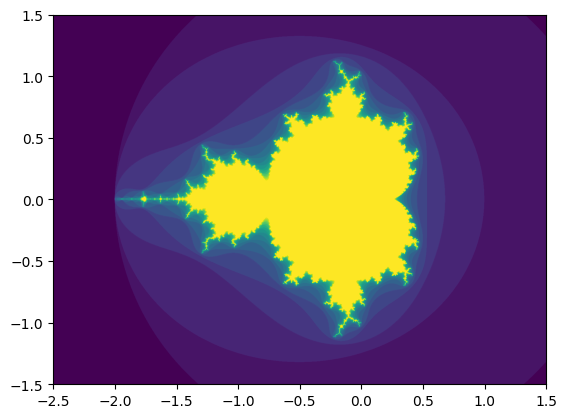

Time taken by compyle: 0.006667501000265474


In [6]:
result = np.array(result_flat)
result.resize((nx, ny))

plt.imshow(result.T, extent=[-2.5, 1.5, -1.5, 1.5])
plt.show()
print("Time taken by compyle:", compyle_time)

In [8]:
print("Speedup wrt numpy vectorised:",np_time/compyle_time)
print("Speedup wrt iterative:",it_time/compyle_time)

Speedup wrt numpy vectorised: 85.10684497493656
Speedup wrt iterative: 1829.4934749187803
